# CNN classificaiton task on CIFAR-10 dataset Analysis

**Group 7 WS2024/25**

**Introduction to Deep Learning**

**Focus Area: Chonvoloutional Neural Networks**




**Summarisation of the project**: In this Project Convolutional Neural Networks has been implemented in order to benchmarking different parameter settings for them.
Parameteres that has been changed accross the layers were **Pooling layer**, **Convolution layer**, **Padding style**,  **Pool type**, **flip kernel**, **Dropout rate** and so on. 

Step **one**: import all neccesary libraries

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

Step **two** : Data Prepration 

In this step we prepare the data by downloading CIFAR-10 data set.

In [3]:
# Data Preparation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./tmp/data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./tmp/data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


Step **three**: CNN implemention 

In this section we define a custom Implementation of the Convoloutional Neural Networks 

In [4]:
class CustomCNN(nn.Module):
    def __init__(self, conv_config, pool_type, dropout_rate, flip_kernel, sparsity=0.0,
                 use_tiled=False, use_unshared=False, use_locally_connected=False, padding_style='same'):
        super(CustomCNN, self).__init__()
        self.layers = nn.ModuleList()
        self.flip_kernel = flip_kernel
        self.sparsity = sparsity
        self.use_tiled = use_tiled
        self.use_unshared = use_unshared
        self.use_locally_connected = use_locally_connected
        self.padding_style = padding_style

        input_channels = 3
        for out_channels, kernel_size, stride, padding in conv_config:
            if self.use_tiled:
                self.layers.append(self.create_tiled_conv(input_channels, out_channels, kernel_size, stride, padding))
            elif self.use_unshared:
                self.layers.append(self.create_unshared_conv(input_channels, out_channels, kernel_size))
            elif self.use_locally_connected:
                self.layers.append(self.create_locally_connected(input_channels, out_channels, kernel_size, stride, padding))
            else:
                self.layers.append(nn.Conv2d(input_channels, out_channels, kernel_size, stride, 0))  
            input_channels = out_channels

        self.pool_type = pool_type
        flattened_size = self.get_flattened_size((3, 32, 32))  
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def compute_padding(self, kernel_size, stride, input_size, padding_style):
        if padding_style == 'valid':
            return 0
        elif padding_style == 'same':
            return ((input_size - 1) * stride + kernel_size - input_size) // 2
        elif padding_style == 'full':
            return kernel_size - 1
        else:
            raise ValueError(f"Unknown padding style: {padding_style}")

    def create_tiled_conv(self, in_channels, out_channels, kernel_size, stride, padding):
        # Custom tiled convolution implementation
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)  
    def create_unshared_conv(self, in_channels, out_channels, kernel_size):
        # Custom unshared convolution using nn.Unfold and nn.Linear
        return nn.Sequential(
            nn.Unfold(kernel_size),
            nn.Linear(kernel_size * kernel_size * in_channels, out_channels)
        )

    def create_locally_connected(self, in_channels, out_channels, kernel_size, stride, padding):
        # Custom locally connected layer implementation
        height, width = 32, 32  
        output_height = (height + 2 * padding - kernel_size) // stride + 1
        output_width = (width + 2 * padding - kernel_size) // stride + 1
        return nn.ModuleList([
            nn.Linear(kernel_size * kernel_size * in_channels, out_channels)
            for _ in range(output_height * output_width)
        ])

    def get_flattened_size(self, input_shape):
        x = torch.zeros(1, *input_shape)
        with torch.no_grad():
            for conv in self.layers:
                x = F.relu(self.custom_conv(conv, x))
                x = self.pool_type(x)
        return x.numel()

    def custom_conv(self, conv, x):
        if isinstance(conv, nn.ModuleList):  
            output = []
            patches = F.unfold(x, kernel_size=3, stride=1).transpose(1, 2)  
            for i, layer in enumerate(conv):
                output.append(layer(patches[:, i]))
            return torch.stack(output, dim=1).view(x.size(0), -1, x.size(2) - 2, x.size(3) - 2)
        elif isinstance(conv, nn.Sequential):  
            return conv(x)
        else: 
            kernel_size = conv.kernel_size[0]
            stride = conv.stride[0]
            input_size = x.shape[-1]
            padding = self.compute_padding(kernel_size, stride, input_size, self.padding_style)

            if self.flip_kernel:
               
                return F.conv2d(x, conv.weight, bias=conv.bias, stride=conv.stride, padding=padding)
            else:
                
                weight = conv.weight
                flipped_weight = torch.flip(weight, dims=[2, 3])  
                return F.conv2d(x, flipped_weight, bias=conv.bias, stride=conv.stride, padding=padding)

    def apply_sparsity(self, weight):
        if self.sparsity > 0.0:
            mask = torch.rand_like(weight) > self.sparsity
            weight = weight * mask.float()  
        return weight

    def forward(self, x):
        for conv in self.layers:
            if hasattr(conv, 'weight'):
                conv.weight.data = self.apply_sparsity(conv.weight.data)
            x = F.relu(self.custom_conv(conv, x))
            x = self.pool_type(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


step *four*: total number of calcaulations

A function for computing Foating point parameters and number of parameters

In [5]:
def calculate_params_and_flops(model, input_shape):
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Count FLOPs
    dummy_input = torch.zeros(1, *input_shape)
    with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
        with record_function("model_inference"):
            model(dummy_input)
    
    flops = sum([event.count for event in prof.key_averages()])
    return total_params, flops


Step **five**: Train the network

In this section the implementation of the training part of the model has been done.

In [6]:
# Training and Evaluation Function
def train_and_evaluate(conv_config, pool_type, dropout_rate, flip_kernel, sparsity, 
                        use_tiled, use_unshared, use_locally_connected, padding_style,
                        train_loader, test_loader, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize model with all the additional parameters
    model = CustomCNN(
        conv_config, 
        pool_type, 
        dropout_rate, 
        flip_kernel, 
        sparsity, 
        use_tiled, 
        use_unshared, 
        use_locally_connected, 
        padding_style
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Calculate Parameters and FLOPs
    total_params, flops = calculate_params_and_flops(model, (3, 32, 32)) 
    print(f"Total Parameters: {total_params}, FLOPs: {flops}")

    # Training Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Evaluation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    
    # Return accuracy, parameters, and FLOPs
    return accuracy, total_params, flops, model


Step **six**: settings

Different settings has been set in order to pass through the channel then plot all various settings to compare them benchmark wise 

Running Experiment 1/13...


STAGE:2025-01-31 15:32:23 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 15:32:23 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 15:32:23 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 41138682, FLOPs: 104


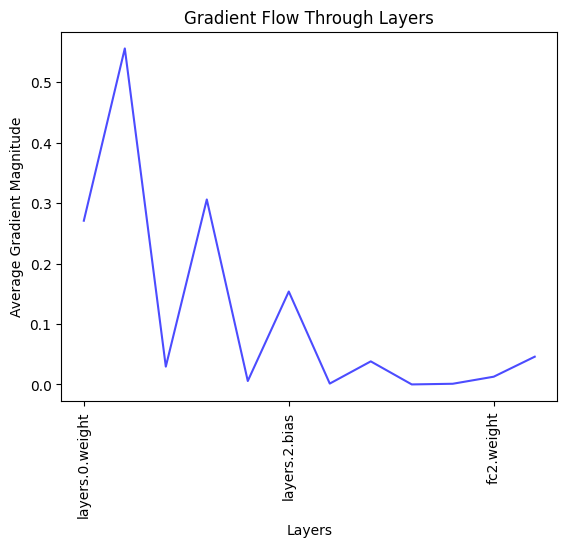

Running Experiment 2/13...
Total Parameters: 5980390, FLOPs: 87


STAGE:2025-01-31 16:04:36 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 16:04:36 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 16:04:36 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


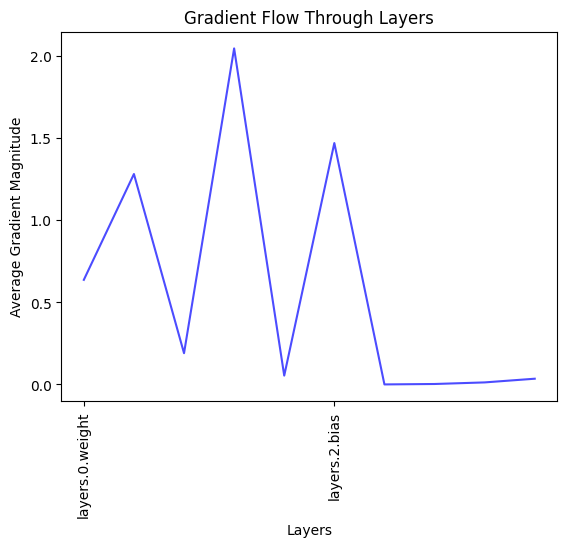

Running Experiment 3/13...


STAGE:2025-01-31 16:09:08 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 16:09:08 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 16:09:08 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 23935354, FLOPs: 129


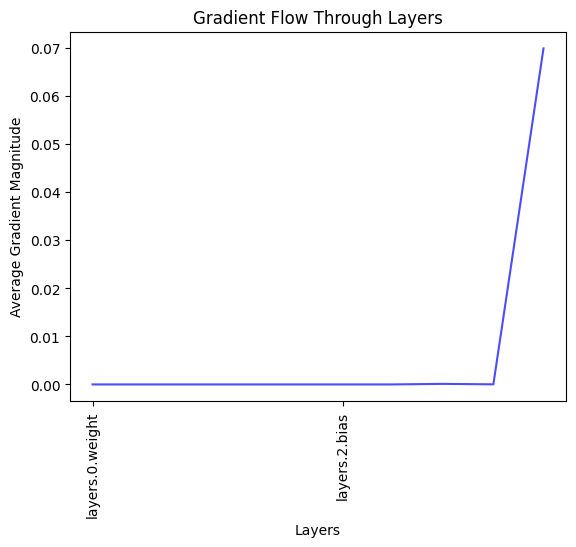

Running Experiment 4/13...


STAGE:2025-01-31 16:26:13 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 16:26:13 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 16:26:13 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 23829738, FLOPs: 87


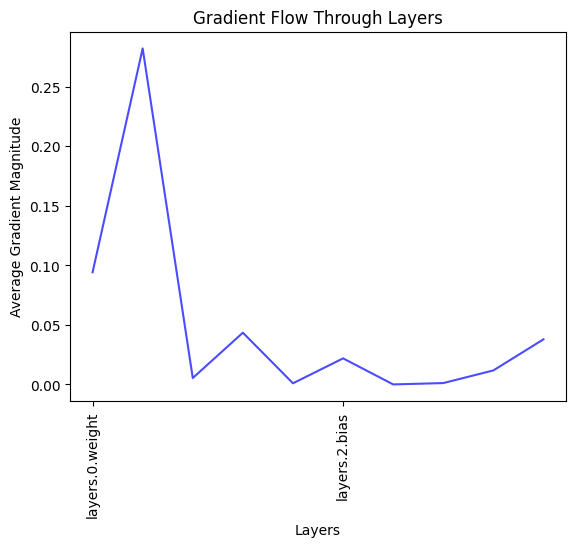

Running Experiment 5/13...


STAGE:2025-01-31 16:53:57 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 16:53:57 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 16:53:57 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 11876730, FLOPs: 87


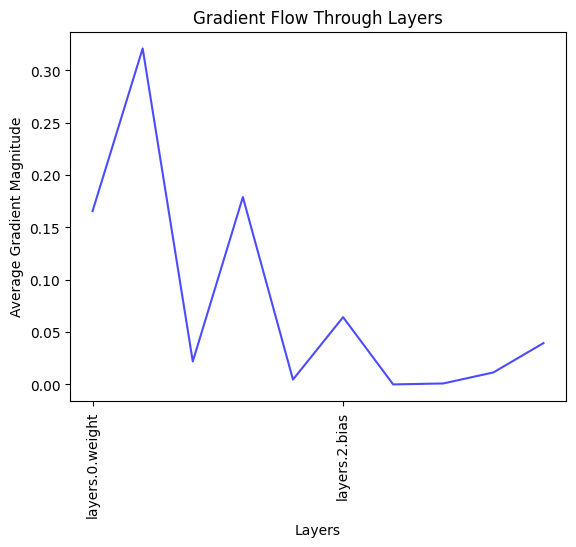

Running Experiment 6/13...


STAGE:2025-01-31 17:06:24 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 17:06:24 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 17:06:24 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 23935354, FLOPs: 129


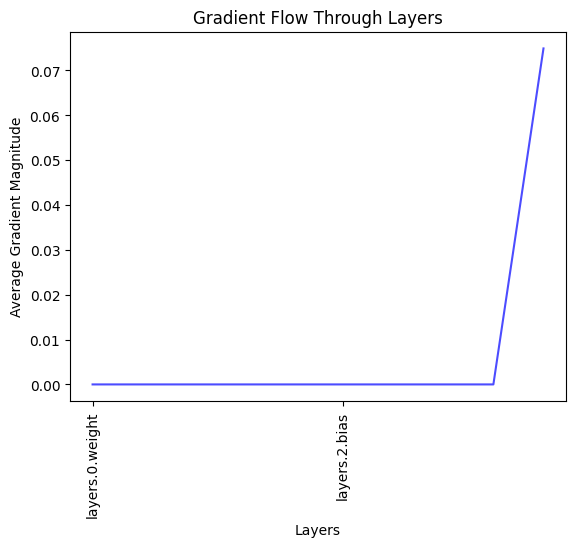

Running Experiment 7/13...


STAGE:2025-01-31 17:26:56 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 17:26:56 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 17:26:56 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 19038794, FLOPs: 122


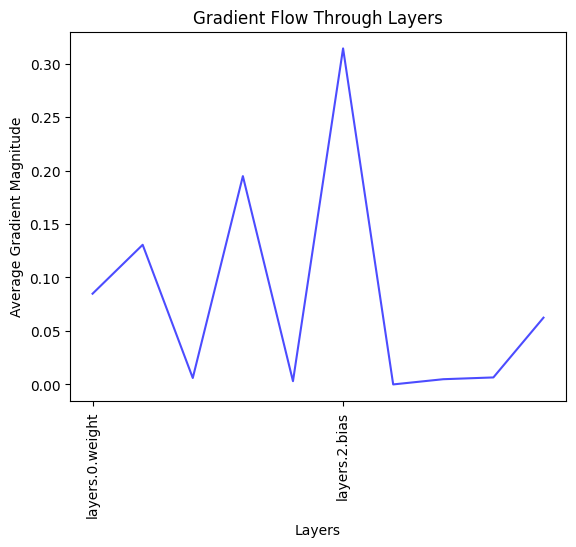

Running Experiment 8/13...


STAGE:2025-01-31 17:58:12 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 17:58:12 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 17:58:12 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 23935354, FLOPs: 117


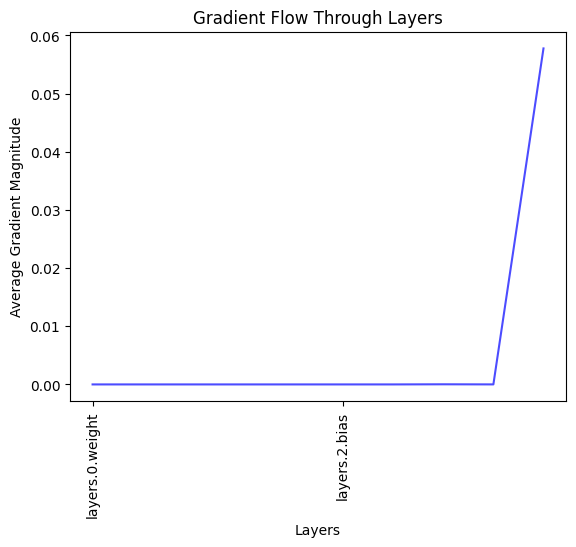

Running Experiment 9/13...


STAGE:2025-01-31 18:18:14 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 18:18:14 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 18:18:14 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 23935354, FLOPs: 75


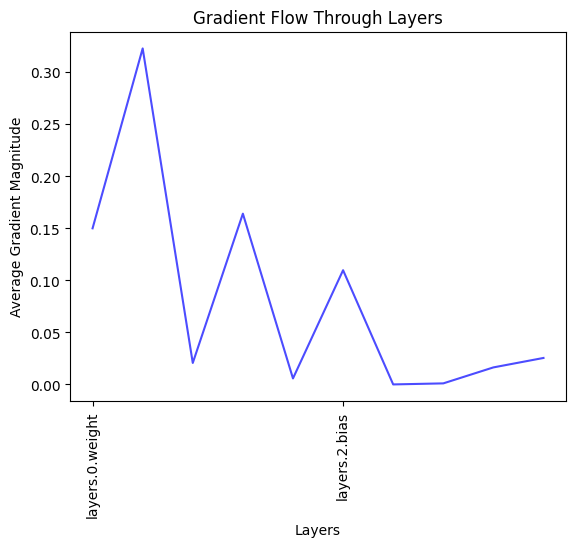

Running Experiment 10/13...


STAGE:2025-01-31 18:36:55 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 18:36:55 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 18:36:55 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 11010890, FLOPs: 109


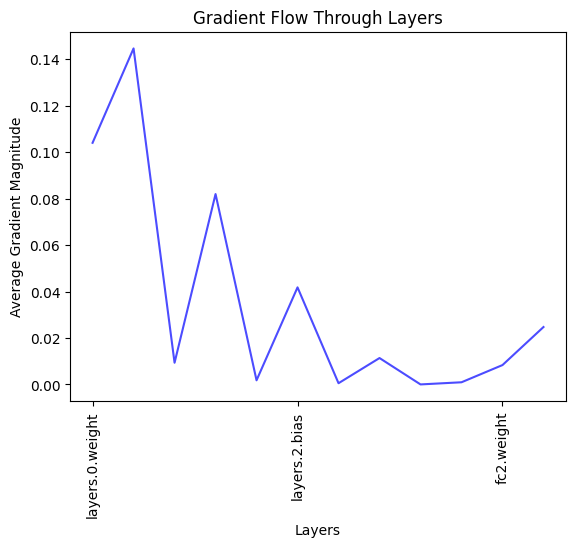

Running Experiment 11/13...


STAGE:2025-01-31 18:56:42 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 18:56:42 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 18:56:42 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 23935354, FLOPs: 84


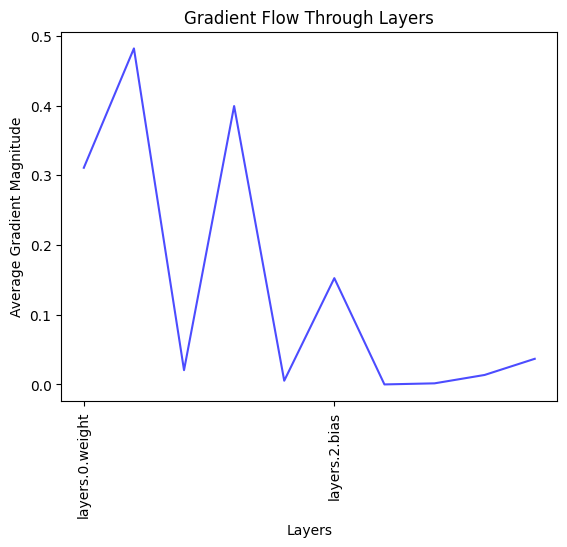

Running Experiment 12/13...
Total Parameters: 11876730, FLOPs: 114


STAGE:2025-01-31 19:13:54 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 19:13:54 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 19:13:54 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


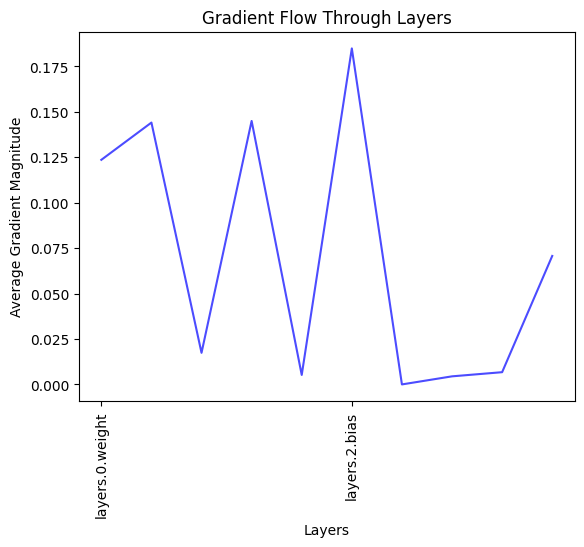

Running Experiment 13/13...


STAGE:2025-01-31 19:29:10 20808:10867348 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-31 19:29:10 20808:10867348 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-31 19:29:10 20808:10867348 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Total Parameters: 48851994, FLOPs: 218


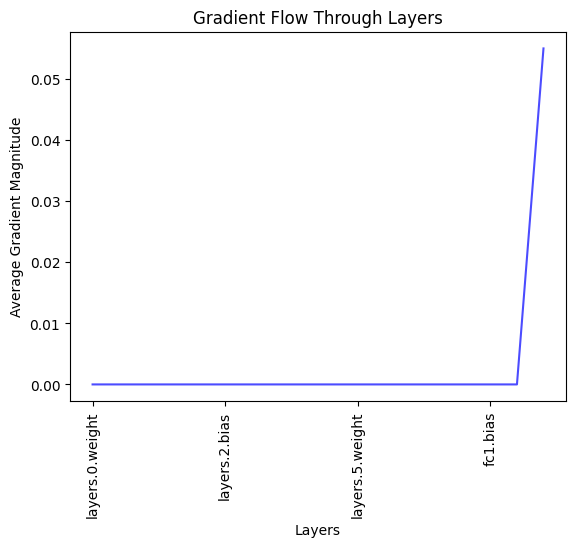

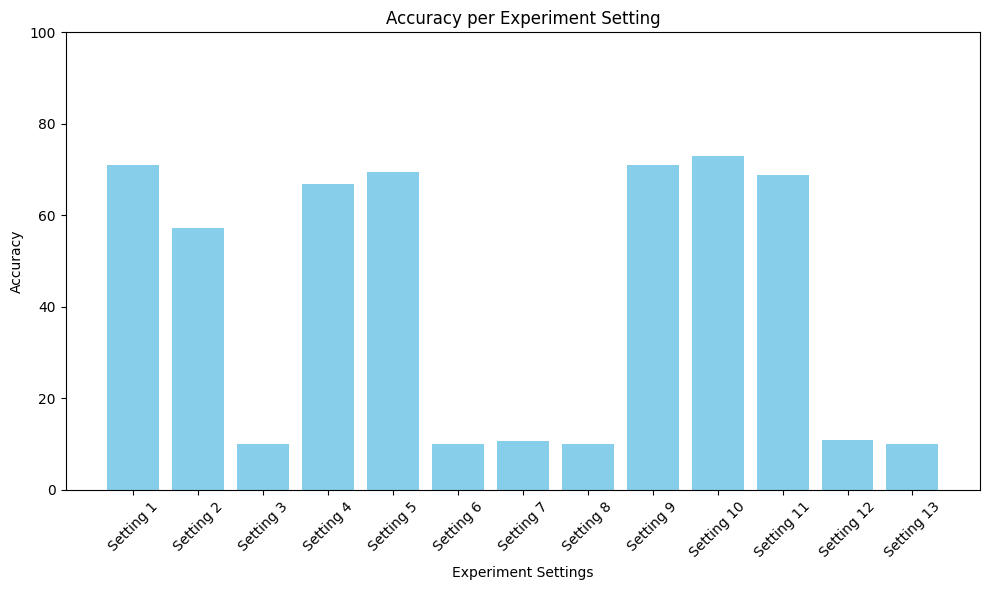

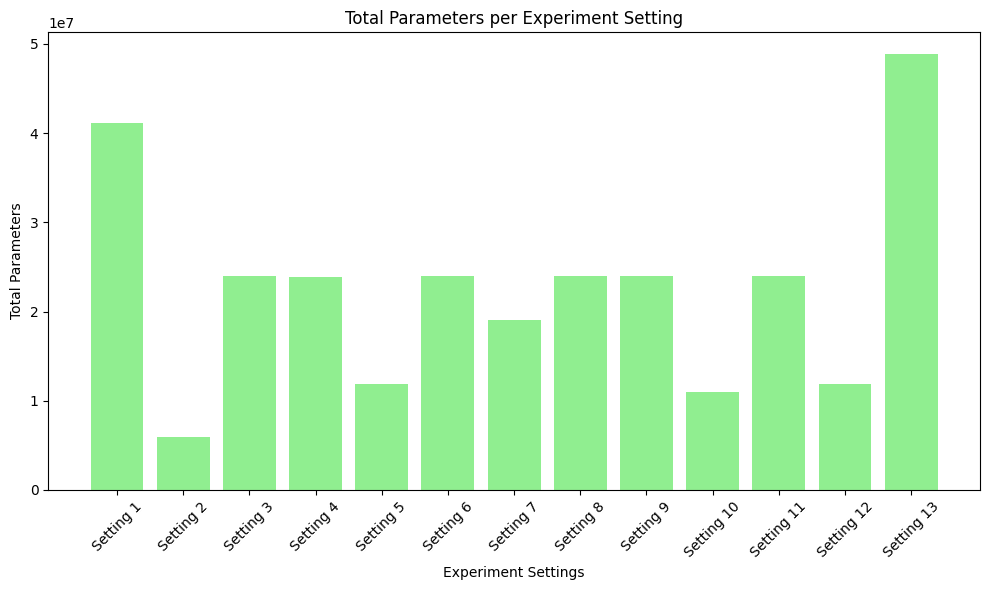

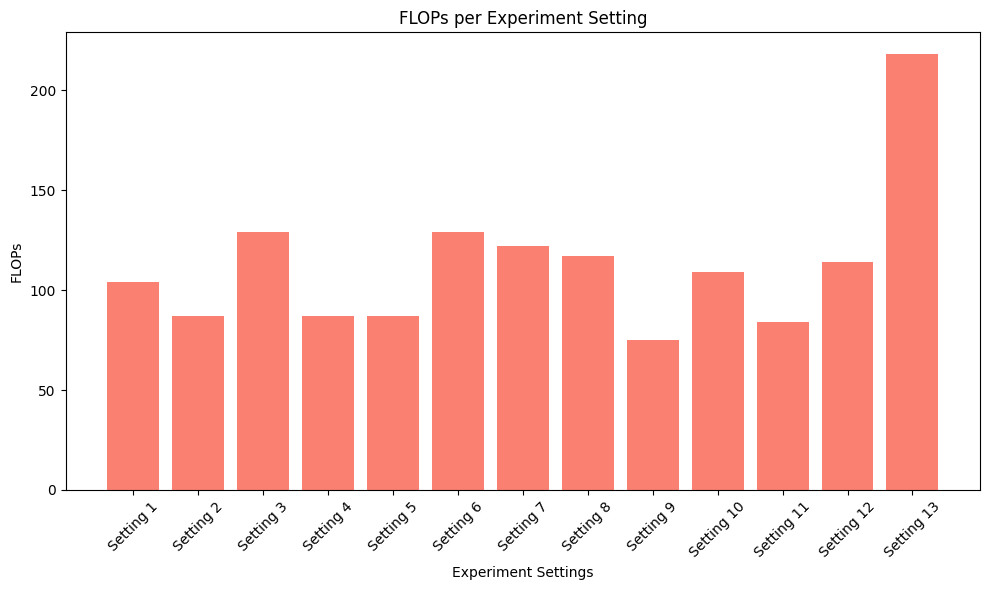

In [7]:
def plot_grad_flow(model):
    ave_grads = []
    layers = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            ave_grads.append(param.grad.abs().mean().item())
            layers.append(name)
    
    plt.plot(ave_grads, alpha=0.7, color='b')
    plt.xticks(range(0, len(layers), 5), layers[::5], rotation=90)
    plt.title("Gradient Flow Through Layers")
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient Magnitude")
    plt.show()
# Experiment Settings
settings = [
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1),(64,4,1,1),(128,4,2,1)] , "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "same"},
    {"conv_config": [(4, 4, 1, 1), (8, 4, 1, 1), (16, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.7, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "same"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.8, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "same"},
    {"conv_config": [(32, 4, 1, 1), (64, 4, 1, 1), (128, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "full"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.1, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "full"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.4, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "same"},
    {"conv_config": [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.2, "flip_kernel": True, "sparsity": 0.1, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "full"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.9, "flip_kernel": True, "sparsity": 0.3, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "same"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": True, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": True, "padding_style": "same"},
    {"conv_config": [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 2, 1),(256, 3, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "full"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.AvgPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "same"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.AvgPool2d(kernel_size=2, stride=1), "dropout_rate": 0.1, "flip_kernel": True, "sparsity": 0.1, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "full"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1),(92,4,2,1),(128,4,2,1),(196,4,2,1),(256,4,2,1)], "pool_type": nn.AvgPool2d(kernel_size=2, stride=1), "dropout_rate": 0.1, "flip_kernel": True, "sparsity": 0.1, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "same"}
]

# Run Experiments and Store Results
results = []
for i, setting in enumerate(settings):
    print(f"Running Experiment {i+1}/{len(settings)}...")

    # Unpack the dictionary 'setting' and pass additional required arguments explicitly
    accuracy, total_params, flops ,model= train_and_evaluate(
        conv_config=setting["conv_config"],
        pool_type=setting["pool_type"],
        dropout_rate=setting["dropout_rate"],
        flip_kernel=setting["flip_kernel"],
        sparsity=setting["sparsity"],
        use_tiled=setting["use_tiled"],
        use_unshared=setting["use_unshared"],
        use_locally_connected=setting["use_locally_connected"],
        padding_style=setting["padding_style"],
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=3
)


    # Store the results
    results.append((f"Setting {i+1}", accuracy, total_params, flops))

    plot_grad_flow(model)

experiment_names = [result[0] for result in results]
accuracies = [result[1] for result in results]
total_params = [result[2] for result in results]
flops = [result[3] for result in results]


# Accuracy per Setting 
plt.figure(figsize=(10, 6))
plt.bar(experiment_names, accuracies, color='skyblue')
plt.title('Accuracy per Experiment Setting')
plt.xlabel('Experiment Settings')
plt.ylabel('Accuracy')
plt.ylim(0, 100)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Plot Total Parameters
plt.figure(figsize=(10, 6))
plt.bar(experiment_names, total_params, color='lightgreen')
plt.title('Total Parameters per Experiment Setting')
plt.xlabel('Experiment Settings')
plt.ylabel('Total Parameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot FLOPs
plt.figure(figsize=(10, 6))
plt.bar(experiment_names, flops, color='salmon')
plt.title('FLOPs per Experiment Setting')
plt.xlabel('Experiment Settings')
plt.ylabel('FLOPs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Step **seven**: Classification

CIFAR-10 dataset has been applied to CNN in order to get the labling predictin so we can observe the accuracy of different settings.

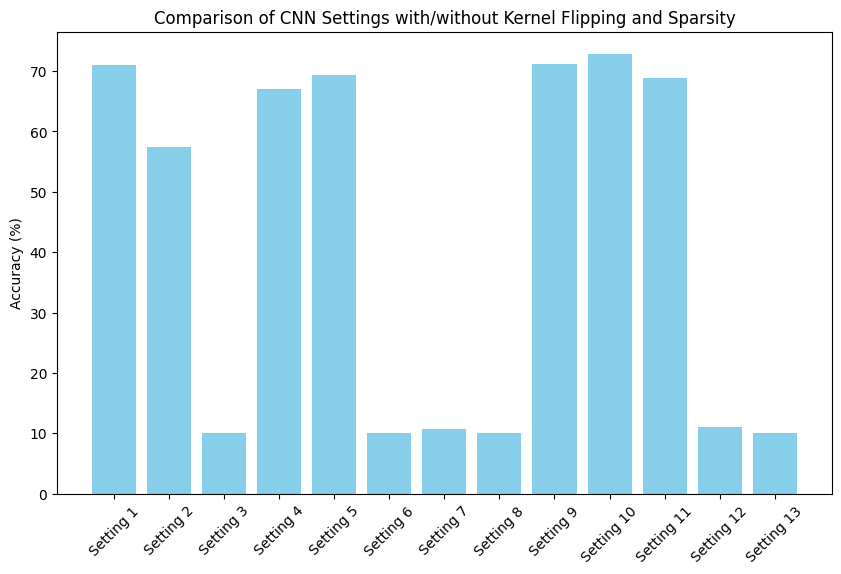

Setting 1: Accuracy = 70.97%, Params = 41138682, FLOPs = 104
Setting 2: Accuracy = 57.35%, Params = 5980390, FLOPs = 87
Setting 3: Accuracy = 10.00%, Params = 23935354, FLOPs = 129
Setting 4: Accuracy = 66.97%, Params = 23829738, FLOPs = 87
Setting 5: Accuracy = 69.39%, Params = 11876730, FLOPs = 87
Setting 6: Accuracy = 10.00%, Params = 23935354, FLOPs = 129
Setting 7: Accuracy = 10.77%, Params = 19038794, FLOPs = 122
Setting 8: Accuracy = 10.00%, Params = 23935354, FLOPs = 117
Setting 9: Accuracy = 71.11%, Params = 23935354, FLOPs = 75
Setting 10: Accuracy = 72.91%, Params = 11010890, FLOPs = 109
Setting 11: Accuracy = 68.81%, Params = 23935354, FLOPs = 84
Setting 12: Accuracy = 11.02%, Params = 11876730, FLOPs = 114
Setting 13: Accuracy = 10.00%, Params = 48851994, FLOPs = 218


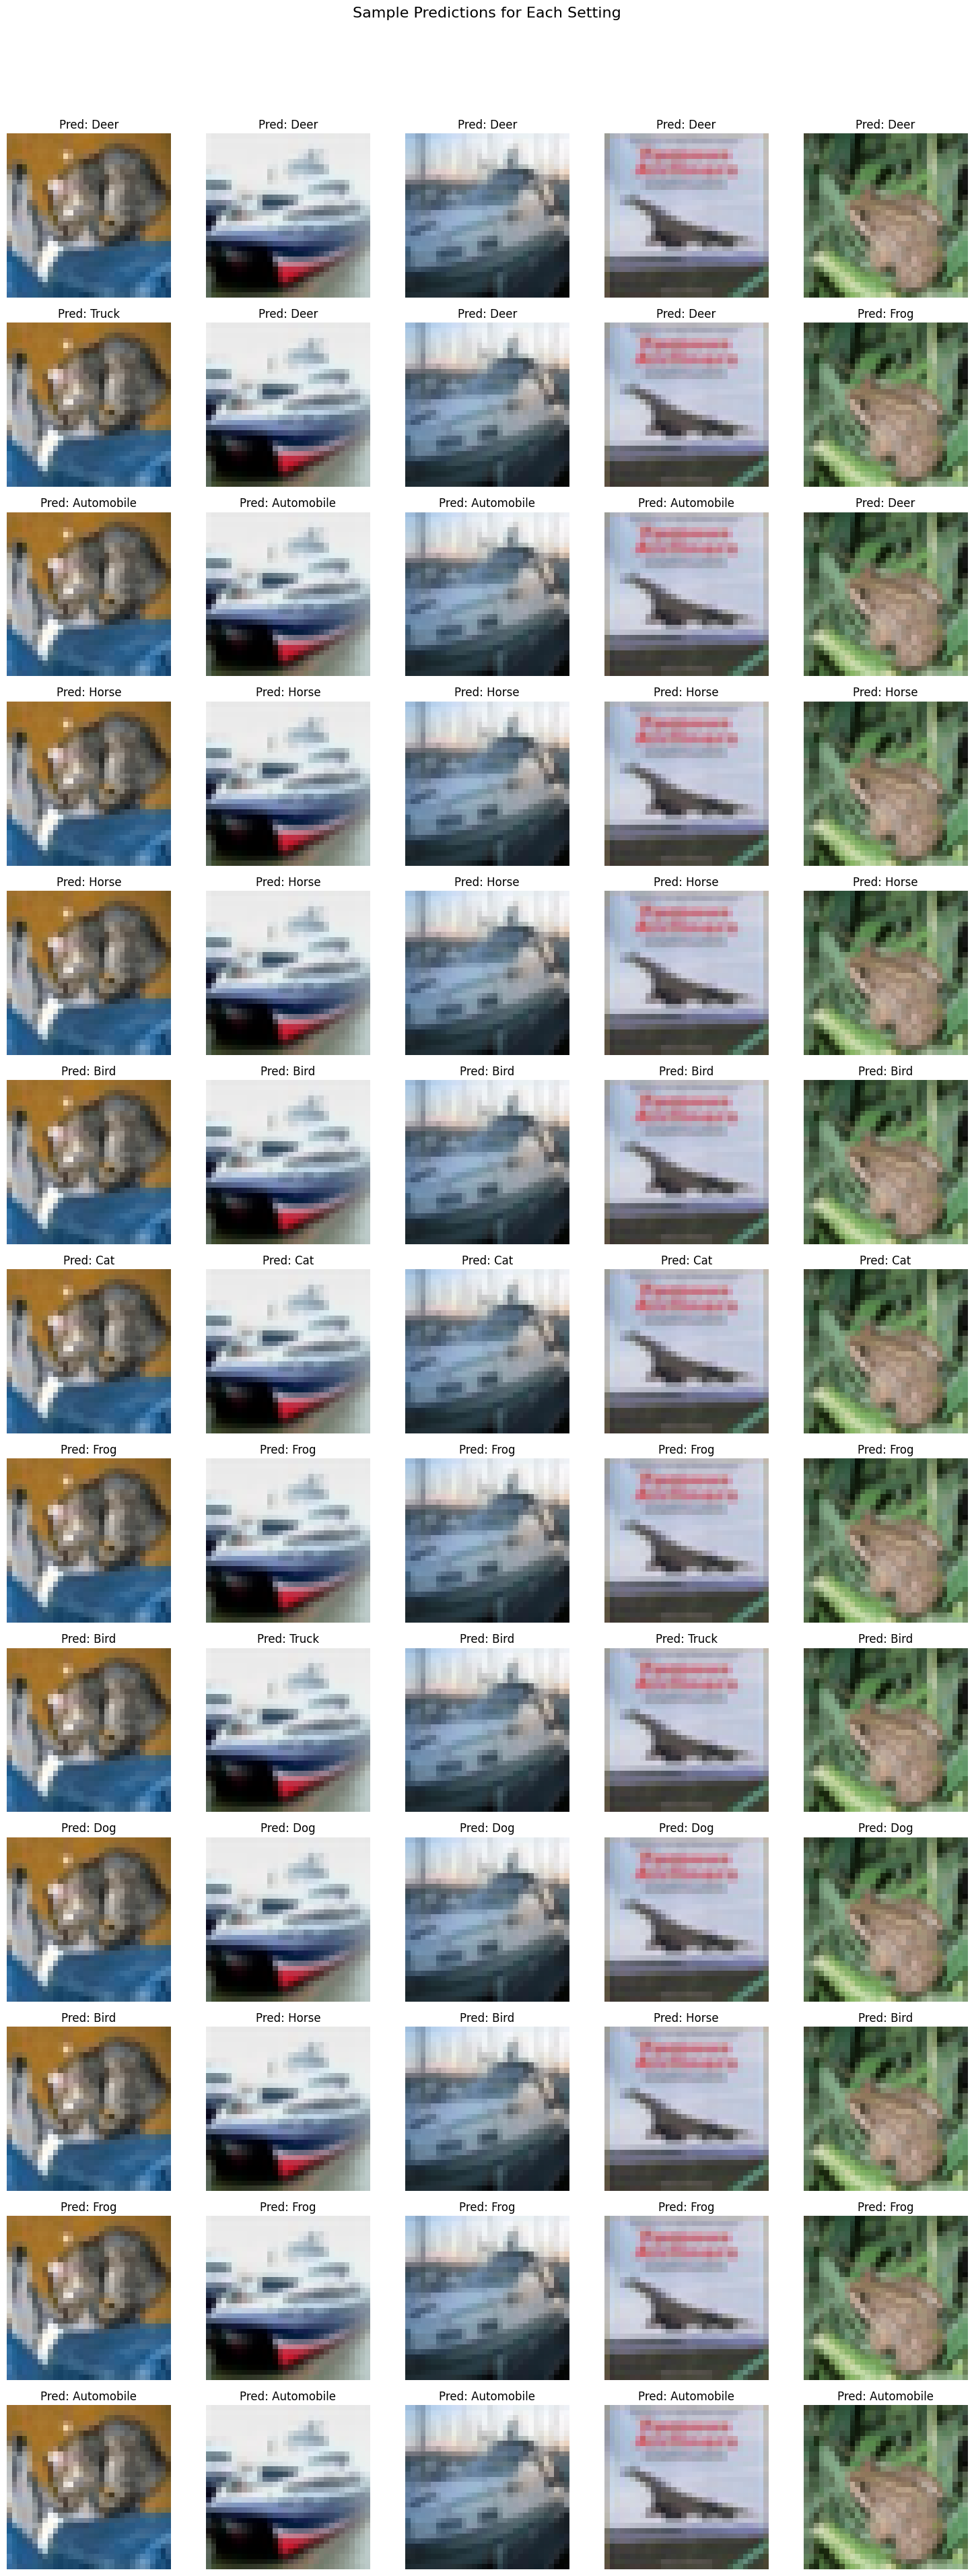

In [8]:
def visualize_results(settings, results, test_loader):
    label_mapping = {
        0:"Airplane",
        1:"Automobile",
        2:"Bird",
        3:"Cat",
        4:"Deer",
        5:"Dog",
        6:"Frog",
        7:"Horse",
        8:"Ship",
        9:"Truck"
    }
    # Plot Accuracy Results
    labels, accuracies, params, flops = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.bar(labels, accuracies, color='skyblue')
    plt.ylabel("Accuracy (%)")
    plt.title("Comparison of CNN Settings with/without Kernel Flipping and Sparsity")
    plt.xticks(rotation=45)
    plt.show()

    # Display Computational Cost Results
    for i, (label, accuracy, param, flop) in enumerate(results):
        print(f"Setting {i+1}: Accuracy = {accuracy:.2f}%, Params = {param}, FLOPs = {flop}")

    # Display Predictions for Each Setting
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Adjust the number of subplots based on settings
    fig, axs = plt.subplots(len(settings), 5, figsize=(15, len(settings) * 3))
    fig.suptitle("Sample Predictions for Each Setting", fontsize=16)

    if len(settings) == 1: 
        axs = axs.reshape(1, 5)  

    for i, setting in enumerate(settings):
        model = CustomCNN(**setting).to(device)
        model.eval()

        samples, predictions = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                samples.extend(inputs[:5].cpu())
                predictions.extend(predicted[:5].cpu())
                break  

        # Plot the Predictions
        for j in range(5):
            axs[i, j].imshow(transforms.ToPILImage()(samples[j] * 0.5 + 0.5))
            axs[i, j].set_title(f"Pred: {label_mapping[predictions[j].item()]}")
            axs[i, j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run Experiments and Visualize
visualize_results(settings, results, test_loader)


**Edge detection task using sobel kernel**

/var/folders/jl/6djzxctx1zsdqhbw2161b3l80000gn/T/ipykernel_20808/3227522834.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

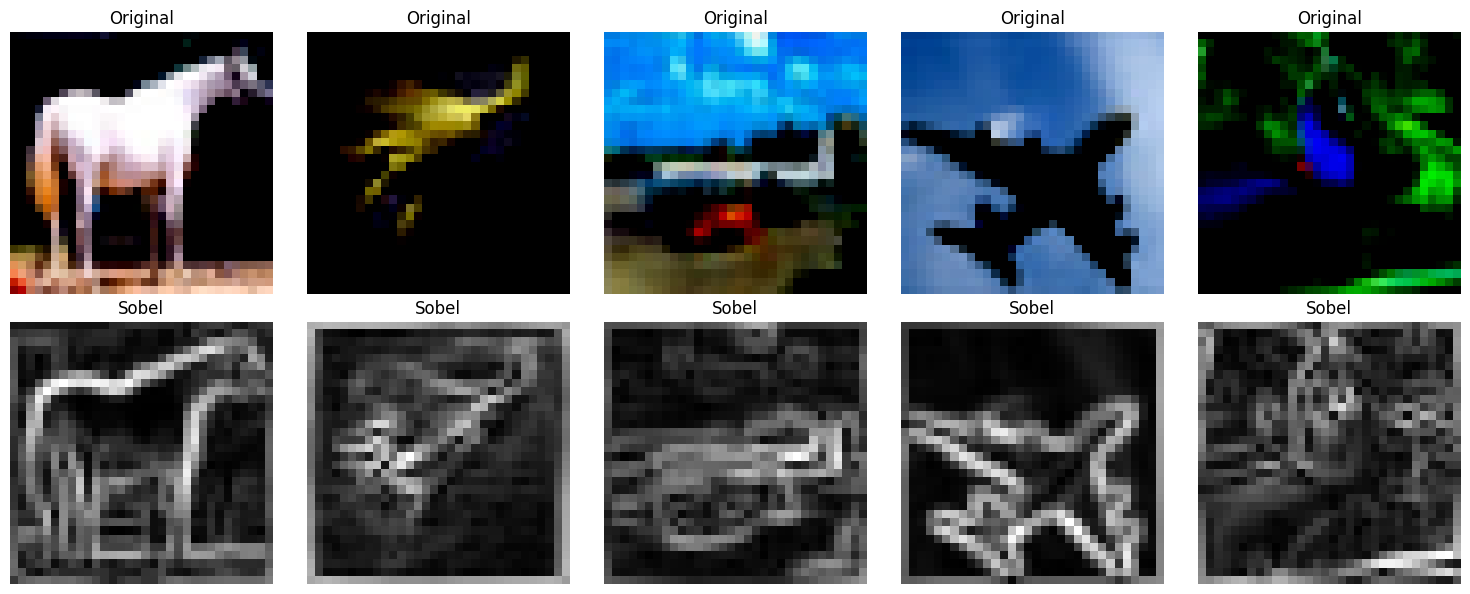

In [11]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define Sobel kernels
sobel_kernel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], dtype=torch.float32)
sobel_kernel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], dtype=torch.float32)

# Function to apply Sobel filter
def apply_sobel_filter(image, sobel_kernel_x, sobel_kernel_y):
    image = torch.tensor(image).unsqueeze(0)  
    if image.shape[1] == 3:  
        image = image.mean(dim=1, keepdim=True)
    sobel_x = F.conv2d(image, sobel_kernel_x, padding=1)
    sobel_y = F.conv2d(image, sobel_kernel_y, padding=1)
    sobel = torch.sqrt(sobel_x ** 2 + sobel_y ** 2)
    return sobel.squeeze(0)  

# Function to plot images
def plot_images(images, titles, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select some random images from the test dataset
random_indices = np.random.choice(len(test_dataset), 5, replace=False)
images = [test_dataset[i][0] for i in random_indices]

# Apply Sobel filter to the selected images
sobel_images = [apply_sobel_filter(image, sobel_kernel_x, sobel_kernel_y) for image in images]

# Plot the original and Sobel filtered images
plot_images(images + sobel_images, ['Original'] * 5 + ['Sobel'] * 5, rows=2, cols=5)